# Project Machine Learning: Group 25
### Peter Bonnarens, Lennert Franssens & Philip Kukoba

# Sprint 1 : Tabular Data

### Possible tasks:
* Thorough exploratory data analysis, e.g.:
    * Are there substantial price differences between neighbourhoods ?
    * Are there hosts with more than one listing ? How does this impact the price ?
    * What is the correlation between the review score and the price ?
    * ...

    Not enough to just show a plot! Clearly describe WHAT question you investigated, WHY you think this is a relevant question
    and WHAT you deduce/conclude from the results of your data analysis

* Are there outliers ?
* A new Airbnb owner needs to pick an appropriate price:
    * Train a model to predict the price based on a selection of features
    * Find the most similar listings
    
* ...

# Table of work (who did what)

<br>

## Exploratory Data Analysis (EDA)
|                   	| EDA step 1 	| EDA step 2A 	| EDA step 2B 	| EDA step 2C 	| EDA step 3A 	| EDA step 3B 	|
|:-----------------:	|:----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|
|  Peter Bonnarens  	|      X     	|             	|      X      	|             	|             	|             	|
| Lennert Franssens 	|      X     	|      X      	|      X      	|             	|      X      	|             	|
|   Philip Kukoba   	|      X     	|             	|             	|      X      	|             	|             	|

<br>

## Linear Regression Model (LR)
|                   	| LR step 1 	| LR step 2 	| LR step 3 	| LR step 4 	|
|:-----------------:	|:---------:	|:---------:	|:---------:	|:---------:	|
|  Peter Bonnarens  	|     X     	|           	|           	|     X     	|
| Lennert Franssens 	|           	|           	|           	|           	|
|   Philip Kukoba   	|           	|           	|           	|           	|

<br>

## K Nearest Neighbors Model (KNN)
|                   	| KNN step 1 	| KNN step 2 	| KNN step 3 	| KNN step 4 	|
|:-----------------:	|:----------:	|:----------:	|:----------:	|:----------:	|
|  Peter Bonnarens  	|            	|            	|            	|            	|
| Lennert Franssens 	|            	|            	|            	|            	|
|   Philip Kukoba   	|            	|            	|            	|            	|

# Exploratory Data Analysis (EDA)

## Step 1: imports & loading the dataset

In [85]:
# imports
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 
from matplotlib import rcParams

from sklearn.neighbors import KDTree
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# figure size in inches
rcParams['figure.figsize'] = 20,16

%matplotlib inline

# loading the dataset into pandas dataframe
listings = pd.read_csv("data/listings.csv")

## Step 2: preprocessing

### 2A : Shift rows
We noticed that some rows in the dataset contained data that was shifted 1 column to the right starting from the 'host_id' column. Instead of removing these rows from the dataset, we decided to shift these rows 1 column back to the left.

In [86]:
# find lines to shift and add them to a mask - we've found that some lines are shifted 1 to the right beginning on the host_id column (that now contains garbage data)
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_id':'reviews_per_month'] = listings.loc[mask, 'host_id':'reviews_per_month'].shift(-1, axis=1)


### MERK OP: er zijn een paar rijen verschoven (bepaalde kolom die weg is ofzo): shift deze rijen!!!

1. host_response_time en host_response_rate: regex om tijdsinterval te kennen, slechte waarden van host_response_time vervangen door juiste waarde in host_response_rate (zie print(listings[ (~listings["host_response_rate"].isnull()) & (~listings["host_response_rate"].str.match('.*%', na=False)) ]) ) en percentage teken bij host_response_rate wegdoen - is omgezet naar een rating (gemakkelijker)
2. host acceptance rate: % wegdoen en omzetten naar float. - % is weggedaan, nog omzetten naar float.. (kan nan niet omzetten naar float)
3. host total listings count: omzetten naar float
4. host verifications: omzetten naar lengte van de array om te kijken op hoeveel manieren een host kan geverifieerd worden (meer trustworthy?)
5. host has profile pic: omzetten naar 0 of 1 (misschien meer geboekt als wel profile pic?)
6. host identity verified: omzetten naar 0 of 1 (misschien meer geboekt als verified?)
7. price omzetten naar float (is ook onze target)
8. 

### 2B : Feature subset selection
Before we start cleaning up the data, we first extract the features we think will be useful to explore during this sprint.

In [87]:
# filter columns
listings = listings[["id", "name", "host_id", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_total_listings_count", "host_verifications", "host_has_profile_pic","host_identity_verified", "neighbourhood_cleansed", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "number_of_reviews", "number_of_reviews_ltm", "last_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "instant_bookable", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "reviews_per_month"]]
# listings.head()
print(listings["id"].unique())

[  187870   203806   204245   216715   252269   440798   476371   565472
   599325   696209   743981   782514   835795   878177   879417   887716
   924683   950284  1018048  1121033  1135017  1141163  1159353  1222069
  1271802  1339383  1354090  1368957  1378568  1418588  1425838  1482891
  1607894  1627743  1638170  1710185  1720808  1723685  1754719  1790941
  1858310  1894366  1981738  2031176  2031654  2043584  2048007  2048223
  2082353  2125334  2138676  2216415  2398101  2495356  2525482  2737715
  2737739  2753095  3120783  3124062  3331706  3373603  3392524  3406443
  3416308  3449406  3519738  3611653  3771542  3798332  3803585  3831324
  3944527  3951890  4042376  4104274  4116739  4275275  4330284  4477376
  4498791  4550799  4591763  4595143  4645775  4696196  4861996  4975295
  5224982  5273113  5303608  5321887  5361495  5498400  5590250  5694820
  5808759  5908287  6054825  6212644  6279703  6290026  6441548  6517280
  6695016  6722473  6807238  6810537  6845309  6883

### 2C : Host response time/rate

In [88]:
# host_response_time
# 0 = best resposne time, 1,2... worse
# listings["host_response_time"].unique()

listings["host_response_time_rating"] = [0 if x == 'within an hour' 
                                         else 1 if x == 'within a few hours' 
                                         else 2 if x == 'within a day' 
                                         else 3 if x == 'a few days or more' 
                                         else None 
                                         for x in listings["host_response_time"]]
listings = listings.drop(columns=["host_response_time"])

#host_response_rate strip trailing % char

listings["host_response_rate"] = [None if x == None else str(x).rstrip('%') for x in listings["host_response_rate"]]
listings["host_response_rate"].unique()




array(['100', 'nan', '50', '90', '0', '88', '57', '78', '71', '67', '83',
       '95', '91', '70', '80', '86', '92', '94', '63', '98', '99', '75',
       '60', '89', '40', '30'], dtype=object)

2D: Convert currency to float

In [89]:
listings['price'] = listings['price'].replace('[\$,)]', '', regex=True).astype(float)

## Step 3 : plots

### 3A : Correlation matrix

<AxesSubplot:>

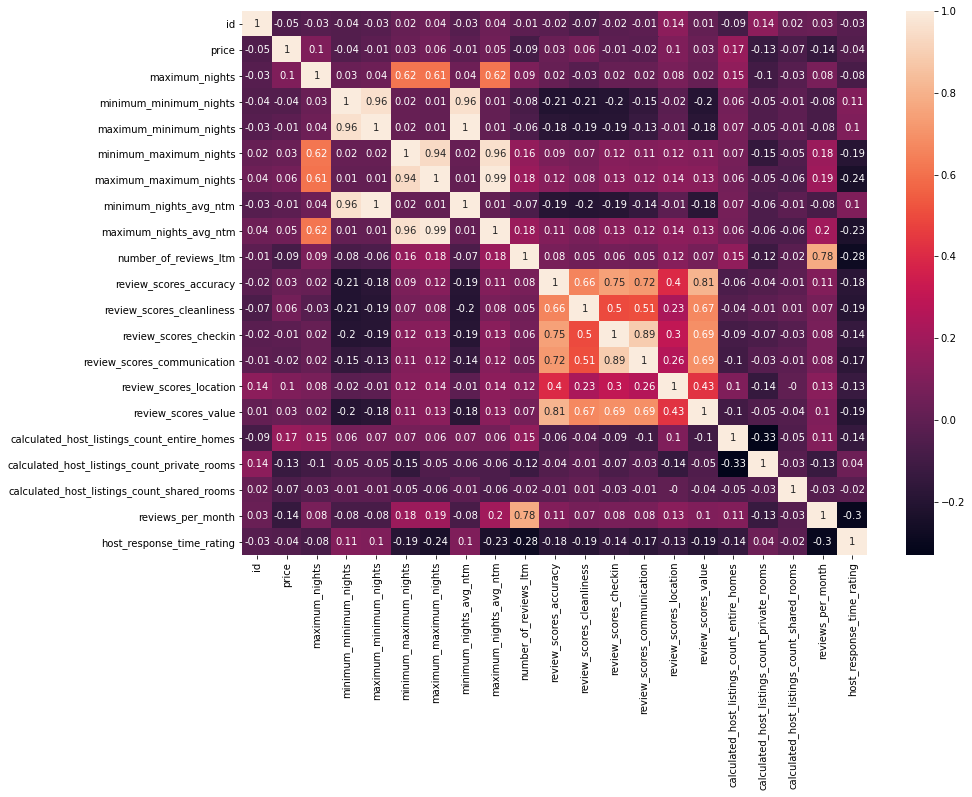

In [90]:
correlation_matrix = listings.corr().round(2)
plt.figure(figsize=(14,10))
sns.heatmap(data=correlation_matrix, annot=True)

# Linear Regression Model

## Step 1 : Train - Test - Split

In [91]:
from sklearn.model_selection import train_test_split

# TODO: insert chosen features into X
X = pd.concat((), axis=1)
Y = listings["price"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

ValueError: No objects to concatenate

## Step 2: Normalizing the data

In [ ]:
# TODO
# formule: x-xmin/xmax-xmin

## Step 3 : Training the model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

y_train_predict = lin_model.predict(X_train)
y_test_predict = lin_model.predict(X_test)

## Step 4 : Measure the performance of the model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# model evaluation for training set
n_train = len(X_train)  # sample size
p_train = len(X_train.columns)  # number of independent variables
R2_train = r2_score(Y_train, y_train_predict)
RMSE_train = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# use the adjusted R² score to counter accidental increase of score with number of input features.
adj_R2_train = 1 - ((1-R2_train) * (n_train-1)/(n_train-p_train-1))   #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

print("Model train performance")
print("--------------------------------------")
print('RMSE is {}'.format(RMSE_train))
print('R2 score is {}'.format(R2_train))
print('adjusted R2 score is {}'.format(adj_R2_train))
print("\n")

# model evaluation for testing set
n_test = len(X_test)
p_test = len(X_test.columns)
R2_test = r2_score(Y_test, y_test_predict)
RMSE_test = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
adj_R2_test = 1 - ((1-R2_test) * (n_test-1)/(n_test-p_test-1))   #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

print("Model test performance")
print("--------------------------------------")
print('RMSE is {}'.format(RMSE_test))
print('R2 score is {}'.format(R2_test))
print('adjusted R2 score is {}'.format(adj_R2_test))
print("\n")


print("Model parameters")
print("--------------------------------------")
print(lin_model.coef_)
print(lin_model.intercept_)

# K Nearest Neighbors Model

## Step 1 : Train - Test - Split

[ 65.  79.  93.  80. 235.  69.  40.  90.  31.  85.  95.  86.  55. 155.
  68. 135.  34. 101. 116.  74.  46.  98.  51.  42. 175.  50.  36.  54.
 194. 132. 120. 340.  71.  77. 134. 115.  84. 143. 139. 163.  96. 130.
 145.  89.  35.  75. 300. 160.  60. 209. 119.  70. 100.  32.  57. 150.
 140. 125.  56. 118.  29. 240. 350.  47. 200.  53.  91.  99.  78. 110.
 202. 113.  22.  49. 156.  20. 214. 172.  52. 169. 250.  23.  73.  76.
 127.  45.  64. 109.  48. 270.  92.  97.  59.  25.  30.  44.  66.  43.
 179. 111.  63. 325. 287.  88.  82. 102. 105. 249. 263. 121. 124.  62.
 185. 237. 289.  58. 191.  37.  39.  26.  87.  94. 269. 170. 103. 189.
  61.  72.  38. 173. 215.  33. 260.  28. 128. 220. 230. 107. 114. 108.
  83. 199. 259.  67. 208. 131. 133. 129.  18.  81. 146.  41. 117. 147.
 245. 190.  27. 154. 144. 151. 315. 223. 112. 142. 104.  21. 201. 375.
 126. 253. 280. 225. 360.  24. 181. 322. 149. 165. 285. 161. 310. 122.
 180. 178. 193.  17.  15.]


/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


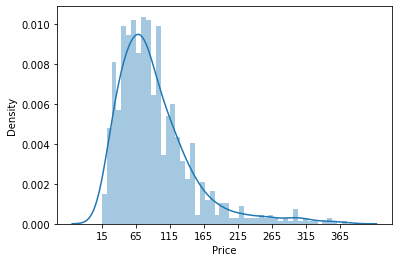

/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/lennertfranssens/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/lennertfranssens/anaconda3/lib/python3.8/site-pac

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

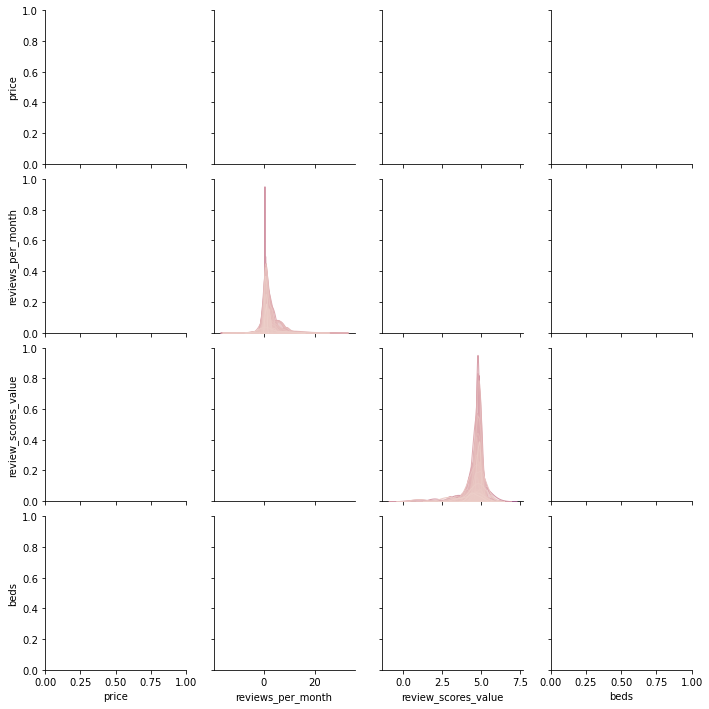

In [98]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

dataset = listings

#dataset.head()
#dataset.describe()
print(dataset.price.unique())
sns.distplot(dataset.price, bins=50)
plt.xlabel("Price")
plt.xticks(np.arange(min(dataset.price.to_numpy()), max(dataset.price.to_numpy()), 50.0))
plt.show()

# TODO
sns.pairplot(dataset, hue="price", vars=["price", "...", "...", "..."])

sns.catplot(x="ca", y="age", kind="swarm", data=dataset, hue="target")
sns.catplot(x="thal", y="chol", kind="swarm", data=dataset, hue="target")


# Replace categorical features with one-hot encodings
a = pd.get_dummies(dataset['cp'], prefix = "cp")
b = pd.get_dummies(dataset['thal'], prefix = "thal")
c = pd.get_dummies(dataset['slope'], prefix = "slope")

frames = [dataset, a, b, c]
dataset = pd.concat(frames, axis = 1)



## Step 2: Normalizing the data

In [ ]:

columns = ["...", "...", "...", "...", "..."]
dataset[columns] = (dataset[columns] - np.min(dataset[columns])) / (np.max(dataset[columns]) - np.min(dataset[columns])).values
dataset.describe()

# Split data in a training and test set
y = dataset.target.values
x = dataset.drop(['target'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

## Step 3 : Training the model

In [ ]:
# The algorithm
class MyKNeighborsClassifier:
    def __init__(self, k):
        self.k = k
    def fit(self, x, y):
        self.tree = KDTree(x)
        self.y = y
    def predict(self, x):
        _, ind = self.tree.query(x, k=self.k)
        return self.y[ind].mean(axis=1)


knn = MyKNeighborsClassifier(10)
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)

predictions

## Step 4: Measure the performance of the model

In [ ]:
accuracy = (predictions == y_test).mean()
print(accuracy)

TP = (predictions[y_test == 1] == 1).sum()
print(TP)

TN = (predictions[y_test == 0] == 0).sum()
print(TN)

FP = (predictions[y_test == 1] == 0).sum()
print(FP)

FN = (predictions[y_test == 0] == 1).sum()
print(FN)

accuracy = (TP+TN)/(TP+TN+FN+FP)
print(accuracy)

precision = TP / (TP + FP)
print(precision)

recall = TP / (TP + FN)
print(recall)

F1 = 2 *  (precision*recall)/(precision+recall)
print(F1)

accuracies = []
for k in range(1, 50):
    knn = MyKNeighborsClassifier(k)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)  > 0.5
    accuracies.append((predictions == y_test).mean())
plt.plot(accuracies)


knn = MyKNeighborsClassifier(5)
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
        
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

for x, y, txt in zip(fpr, tpr, thresholds):
    plt.annotate(np.round(txt,2), (x, y-0.04))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")